In [120]:
import time
import pandas as pd
import numpy as np
import util
import pyBigWig
import seaborn as sns
import glob
from matplotlib_venn import venn2,venn3
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
tic=time.time()
source='data/source/'
def get_cg(x):
    cg=set(range(x['b'],x['e']))
    cg=ind[x['ch']].intersection(cg)
    return cg
def hmr2df(hmr):
    gs=pd.read_table(hmr,header=None,usecols=[0,1,2])
    gs=gs[~gs[0].isin(['chrX','chrY','chrM'])]
    print(len(gs),end=',')
    gs.columns=['ch','b','e']   
    gs['d']=gs['e']-gs['b']
    gs['r']=gs.apply(lambda x:get_cg(x) ,axis=1)
    gs['rd']=gs.r.apply(lambda x:len(x))
    gs.index=gs['ch']+'_'+gs['b'].astype(str)
    gg=gs.groupby('ch')['r'].apply(list)
    gg=gg.apply(lambda x:set.union(*x))    
    return (gs,gg)   
def get_ts(x):
    chrom=x['ch']
    com=set(range(x['b'],x['e'])).intersection(expg[chrom])
    if len(com)>0:
        ts=list(com)[0]
        ts=exp.loc[(exp['chrom']==int(chrom[3:])) & (exp.ts==ts)].index.values[0]
    else:
        ts=np.nan
    return(ts)

In [2]:
ind=pd.read_table('data/meth/h/Human_H1.meth',engine='c',usecols=[0,1],header=None)
ind=ind.groupby(0)[1].apply(list)
ind=ind.apply(lambda x:set(x))

In [3]:
samples=['s','t','h']
c={}
cg={}
cu={}
cug={}

In [4]:
for s in samples:
    c[s],cg[s]=hmr2df('data/meth/'+s+'/'+s+'.hmr')

95351,52648,39517,

In [5]:
c['t']['s']=c['t'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r'])),1)
c['t']['sh']=c['t'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r']).intersection(cg['h'][x['ch']])),1)
c['s']['t']=c['s'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r'])),1)
c['s']['th']=c['s'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r']).intersection(cg['h'][x['ch']])),1)

In [6]:
c['h']['t']=c['h'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r'])),1)
c['h']['s']=c['h'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r'])),1)

In [7]:
print(round(c['t']['rd'].sum()/10**3),
      round(c['t']['s'].sum()/10**3),
      round(c['t'][c['t']['s']>0]['sh'].sum()/10**3))
print(round(c['s']['rd'].sum()/10**3),
      round(c['s']['t'].sum()/10**3),
      round(c['s'][c['s']['t']>0]['th'].sum()/10**3))

2609 2352 2144
3486 2352 2144


In [8]:
def van():
    ct,cs,ch=[],[],[]
    for i,r in c['t'].iterrows():
        for j in list(r['r']):
            ct.append(r['ch']+'_'+str(j))
    for i,r in c['s'].iterrows():
        for j in list(r['r']):
            cs.append(r['ch']+'_'+str(j)) 
    for i,r in c['h'].iterrows():
        for j in list(r['r']):
            ch.append(r['ch']+'_'+str(j))        
    pd.DataFrame(ct).to_csv('data/ti.csv',index=False,header=False)
    pd.DataFrame(cs).to_csv('data/si.csv',index=False,header=False)
    pd.DataFrame(ch).to_csv('data/hi.csv',index=False,header=False)        
    subsets=(set(cs),set(ct),set(ch))
    v=venn3(subsets = subsets, set_labels = ('HMR in Epidermis', 'HMR in T cells','HMR in ESC'))

In [9]:
for s in ['s','t']:
    for n in ['y','o']:
        path='data/meth/'+s+'/'+n+'.bw'
        bw=pyBigWig.open(path)
        c[s][n]=c[s].apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
    c[s]['dd']=c[s]['o']-c[s]['y']
    cu[s]=c[s][c[s]['dd']>.1]
    cug[s]=cu[s].groupby('ch')['r'].apply(list)
    cug[s]=cug[s].apply(lambda x:set.union(*x))                   
cu['t']['su']=cu['t'].apply(lambda x:len(cug['s'][x['ch']].intersection(x['r'])),1)
cu['t']['suh']=cu['t'].apply(lambda x:len(cug['s'][x['ch']].intersection(cg['h'][x['ch']]).intersection(x['r'])),axis=1)
cu['s']['tu']=cu['s'].apply(lambda x:len(cug['t'][x['ch']].intersection(x['r'])),1)
cu['s']['tuh']=cu['s'].apply(lambda x:len(cug['t'][x['ch']].intersection(cg['h'][x['ch']]).intersection(x['r'])),axis=1)
print(round(cu['t'].rd.sum()/10**3),
      round(cu['t']['su'].sum()/10**3),
      round(cu['t'][cu['t']['su']>0]['suh'].sum()/10**3))
print(round(cu['s'].rd.sum()/10**3),
      round(cu['s']['tu'].sum()/10**3),
      round(cu['s'][cu['s']['tu']>0]['tuh'].sum()/10**3))

259 27 15
95 27 15


In [10]:
#cu['t'][['ch','b','e','su','suh']].to_csv('data/tu.csv')
#cu['s'][['ch','b','e','tu','tuh']].to_csv('data/su.csv')

In [11]:
def vanAge():
    ct,cs,=[],[]
    for i,r in cu['t'].iterrows():
        for j in list(r['r']):
            ct.append(r['ch']+'_'+str(j))
    for i,r in cu['s'].iterrows():
        for j in list(r['r']):
            cs.append(r['ch']+'_'+str(j)) 
    subsets=(set(cs),set(ct),set(ch))
    venn3(subsets = subsets, set_labels = ('ageHMR in Epidermis', 'ageHMR in T cells','HMR in ESC'))

In [237]:
bw='data/source/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
ts=cu['t'][cu['t']['su']>0]
st=cu['s'][cu['s']['tu']>0]
bs=[]
for i,r in ts.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
ts['EZH2']=bs    
bs=[]
for i,r in st.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
st['EZH2']=bs    

In [238]:
bw=source+'ENCFF609MMJ.bigWig'
bw=pyBigWig.open(bw)
bs=[]
for i,r in ts.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
ts['SUZ12']=bs    
bs=[]
for i,r in st.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
st['SUZ12']=bs    

In [239]:
print(ts[ts.suh==0].EZH2.mean(),ts[ts.suh>0].EZH2.mean())
print(st[st.tuh==0].EZH2.mean(),st[st.tuh>0].EZH2.mean())

2.892130427157452 40.63913004243051
2.9151432654522944 40.820904419018945


In [240]:
print(ts[ts.suh==0].SUZ12.mean(),ts[ts.suh>0].SUZ12.mean())
print(st[st.tuh==0].SUZ12.mean(),st[st.tuh>0].SUZ12.mean())

2.954944704872758 43.77948179267556
2.9289105135828004 44.725046445130616


In [241]:
print(ts.rd.sum()/cu['t'].rd.sum())
print(st.rd.sum()/cu['s'].rd.sum())

0.14361480704892
0.35914103308183404


In [271]:
ts.loc[ts.suh>0,'group']='AgeLMRs within ESC LMRs'
ts.loc[ts.suh==0,'group']='AgeLMRs outside ESC LMRs'

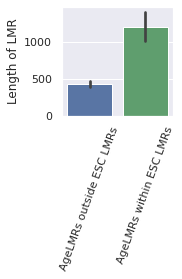

In [272]:
sns.set(rc={'figure.figsize':(2,2)})
pl=ts[['group','d']]
ax=sns.barplot(data=pl,x='group',y='d',palette=sns.color_palette(['b','g','y']))
ax.set(xlabel='',ylabel='Length of LMR');
plt.xticks(rotation=70);

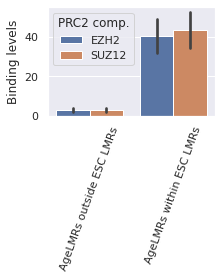

In [273]:
pl=ts[['group','EZH2','SUZ12']].melt('group')
pl.columns=['Group','PRC2 comp.','Binding']
sns.set(rc={'figure.figsize':(3,2)})
ax=sns.barplot(data=pl,x='Group',y='Binding',hue='PRC2 comp.')
ax.set(xlabel='',ylabel='Binding levels');
plt.xticks(rotation=70);

In [253]:
tmp_='https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz'
tpm=pd.read_csv(tmp_,sep='\t',skiprows=2,index_col=0)
tpm=tpm.groupby('Description').mean()

In [254]:
mane=pd.read_table(source+'mane.gz')

In [255]:
mane['tss']=mane.apply(lambda x:x['chromStart'] if x['strand']=='+' else x['chromEnd'],axis=1)

In [256]:
tpm=tpm[['Whole Blood','Skin - Sun Exposed (Lower leg)']].merge(mane[['geneSymbol','#chrom','tss']],left_index=True,right_on='geneSymbol')

In [257]:
tpmg=tpm.groupby('#chrom')['tss'].apply(set)

In [259]:
ts['tpm']=ts.apply(lambda x:len(set(range(x['b'],x['e'])).intersection(tpmg[x['ch']])),axis=1)

In [260]:
ts.value_counts('tpm')

tpm
0    734
1     91
2      2
dtype: int64

In [261]:
ts['blood']=ts.apply(lambda x: tpm[(tpm['#chrom']==x['ch'])&(tpm['tss'].isin(range(x['b'],x['e'])))]['Whole Blood'].values[0] if x['tpm']==1 else np.nan ,axis=1)
ts['skin']=ts.apply(lambda x: tpm[(tpm['#chrom']==x['ch'])&(tpm['tss'].isin(range(x['b'],x['e'])))]['Skin - Sun Exposed (Lower leg)'].values[0] if x['tpm']==1 else np.nan ,axis=1)


In [263]:
ts.groupby('group').median()

,b,e,d,rd,s,sh,y,o,dd,su,suh,EZH2,SUZ12,tpm,blood,skin
group,,,,,,,,,,,,,,,,
AgeLMRs outside ESC LMR,60430834.5,60431309.5,317.5,18.0,15.5,0.0,0.163095,0.381252,0.190558,15.0,0.0,1.01688,0.73499,0.0,0.000000,0.454153
AgeLMRs within ESC LMR,53889693.0,53890325.0,632.0,33.0,28.0,23.0,0.090548,0.272751,0.164437,25.0,21.0,4.74542,4.34706,0.0,0.034541,0.916598


In [27]:
############################
############################

In [122]:
h=c['h'].copy()
bw='data/source/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
bs=[]
for i,r in h.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
h['ez']=bs

In [125]:
bw='data/source/ENCFF609MMJ.bigWig'
bw=pyBigWig.open(bw)
bs=[]
for i,r in h.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
h['suz']=bs

In [128]:
h['prc']=h[['ez','suz']].mean(1)

In [138]:
h[['ch','b','e','d','rd','ez','suz','prc']].to_csv('data/h.csv')

In [134]:
hz=h[h.prc>100].copy()

In [135]:
tss=pd.read_csv('data/tss.csv',index_col=0)
exp=pd.read_csv('data/exp.csv',index_col=0)
exp['ch']='chr'+exp['chrom'].astype(str)
expg=exp.groupby('ch')['ts'].apply(list)
hz['ts']=hz.apply(lambda x: get_ts(x),axis=1)
hzt=hz[hz.ts.notna()]
len(hzt)

633